In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import relativedelta as rdelta
from datetime import date, timedelta
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import chi2_contingency, f_oneway

# Ayiti Analytics Probability and Statistics Project

Use all the files to have a final datasets to have the following columns
   <ul>
    <li>questid</li>
    <li>gender</li>
    <li>age (age of applicant)</li>
    <li>communeName (use data prep in commune file)</li>
    <li>application_date (created at in quest file)</li>
    <li>enroll_date (created_at in enroll file)</li>
    <li>is_enroll (Yes/No) (use data prep in enroll file)</li>
    <li>Education Level</li>
   <li>Communication channels(hear_AA1)</li>
    <li>Bootcamp Insterest (after_AA)</li>
    <li>Payement Date (use ord and transaction files)</li>
    <li>Payed (Yes/No)</li>
    <li>list Technologies as columns based (use get_dummies)</li>
    <li>list  Study domains (use get_dummies)</li>
    <li>Job is formal</li>
    <li>Have computer at home</li>
    <li>Have internet at home</li>
    
   </ul>
   

In [348]:
commune = pd.read_excel(r"commune.xlsx")
enroll = pd.read_csv(r"enroll.csv")
quest = pd.read_csv(r"quest.csv")
industry = pd.read_csv(r"industry.csv")
ord = pd.read_csv(r"ord.csv")
study_domain = pd.read_csv(r"study_domain.csv")
transaction = pd.read_csv(r"transaction.csv")
technology = pd.read_csv(r"technology.csv")

In [349]:
# read_file(file_name = "quest_crv")
len(quest)

250

In [350]:

def merging (a,b):
    df= pd.merge(left =b , right = b, how = "left", on = "quest_id") 
    return df

In [351]:
 def dumies (data):
     dum = pd.get_dummies(data[["key", "quest_id", "values"]], columns=['values'], prefix="", prefix_sep="")
     df= dum.groupby(by=["quest_id"]).sum()
     return df

In [352]:
commune1 = commune.copy()
commune1["Commune_Id"] = commune1["Commune_Id"].str.lower()
commune1.rename(columns = {"Commune_Id": "commune"}, inplace = True)

In [353]:
commune1.drop(["ADM1_PCODE", "Commune_FR"], axis=1, inplace=True)

In [354]:
technology1 = dumies(technology)

In [355]:
study_domain1 = dumies(study_domain)

In [356]:
technology1.shape

(244, 12)

In [357]:
enroll.rename(columns = {"created_at": "enroll_date"}, inplace = True)
enroll['is_enroll'] = np.where(enroll['enroll_date'].isna(), 'no', 'yes')
enroll1=enroll[["enroll_date","is_enroll","quest_id","user_id"]]

In [358]:
enroll1

,enroll_date,is_enroll,quest_id,user_id
0,2020-12-12T06:41:29.844Z,yes,NaN,29816173
1,2020-12-13T14:41:17.720Z,yes,NaN,35229766
2,2020-12-15T00:53:06.499Z,yes,NaN,31987560
3,2020-12-18T18:38:55.683Z,yes,NaN,35616451
4,2020-12-21T14:45:06.528Z,yes,NaN,35390649
...,...,...,...,...
143,2021-03-14T02:16:08.736Z,yes,906b65e3-ce95-11eb-a294-7c67a234f601,41508160
144,2021-03-14T04:20:30.803Z,yes,906636cf-ce95-11eb-8679-7c67a234f601,41564742
145,2021-03-14T07:34:09.491Z,yes,906241d5-ce95-11eb-9850-7c67a234f601,41569249
146,2021-03-14T15:34:39.800Z,yes,906b3c86-ce95-11eb-b6a7-7c67a234f601,41587952


In [359]:


quest1 = quest.drop(["Unnamed: 0", "modified_at","department", "university", "study_domain", "current_employed"], axis=1)

In [360]:
def new_date(data, col=""):
  data[col] = data[col].str[:10]
  data[col] = pd.to_datetime(data[col])
  return col

In [361]:
quest1.rename(columns={"created_at": "application_date", "hear_AA_1":"Communication channels","after_AA":"Bootcamp interest", "formal_sector_job":"job is formal"}, inplace=True)
new_date(quest1, col="application_date")
quest1["dob"].replace({"3 aout 1977": "3/08/1977"}, inplace=True)
quest1["dob"] = pd.to_datetime(quest1["dob"])

In [362]:
quest1["age"] = (-(quest1["dob"]-quest1["application_date"])//np.timedelta64(1,"Y"))

In [363]:
quest1.columns

Index(['gender', 'dob', 'commune', 'application_date', 'education_level',
       'job is formal', 'have_computer_home', 'internet_at_home',
       'Communication channels', 'Bootcamp interest', 'quest_id', 'age'],
      dtype='object')

In [364]:
quest1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gender                  250 non-null    object        
 1   dob                     244 non-null    datetime64[ns]
 2   commune                 250 non-null    object        
 3   application_date        250 non-null    datetime64[ns]
 4   education_level         250 non-null    object        
 5   job is formal           250 non-null    object        
 6   have_computer_home      250 non-null    object        
 7   internet_at_home        250 non-null    object        
 8   Communication channels  250 non-null    object        
 9   Bootcamp interest       250 non-null    object        
 10  quest_id                250 non-null    object        
 11  age                     244 non-null    float64       
dtypes: datetime64[ns](2), float64(1), object(9)
memory

In [365]:
ord1 = ord.loc[:, ["created_at", "user_id"]]
transaction1 = transaction.loc[:, ["created_at", "user_id"]]
ord1.rename(columns={"created_at": "payment_date"}, inplace=True)
transaction1.rename(columns={"created_at": "payment_date"}, inplace=True)
ord_transac = pd.concat([transaction1, ord1], axis=0)
new_date(ord_transac, "payment_date")
ord_transac["payed"] = "yes"

In [366]:
enroll_payed = pd.merge(left=enroll1, right=ord_transac, how="left", on="user_id")

In [367]:
dts = pd.merge(left=quest1, right= commune1, on="commune", how="left")
dts = pd.merge(left=dts, right= enroll_payed, on="quest_id", how="left")
dts = pd.merge(left=dts, right= study_domain1, on="quest_id", how="left")
dts = pd.merge(left=dts, right= technology1, on="quest_id", how="left")

In [368]:

dts.drop(["dob", "commune"], axis=1, inplace=True)

In [369]:
def add_no(data=dts, col="", text="no"):
  data[col].fillna(text, inplace=True)
add_no(col="is_enroll")
add_no(col="payed")

###  1. How many observations and variables are there in the dataset
 

In [370]:
# here your codes
print(f"The final dataset has {dts.shape[0]} observations and {dts.shape[1]} variables.")

The final dataset has 250 observations and 38 variables.


### 2.A Calculate the average age of the observations
   * On the whole dataset
   * On the whole male dataset
   * On all the female dataset
### 2.B Calculate 
   * variance of the whole datatset,male and female
   * kurtosis of the whole datatset,male and female
   * skewness of the whole datatset,male and female
### 2.C Does the age distribution follow a normal distribution 
   

In [371]:
# here your codes
dts[dts.age<2]

,gender,application_date,education_level,job is formal,have_computer_home,internet_at_home,Communication channels,Bootcamp interest,quest_id,age,Commune_en,Departement,enroll_date,is_enroll,user_id,payment_date,payed,Accounting,Computer Science,Economics,Electrical Engineering,Law,Management,Medicine,Statistics,other_x,Bash,Excel,Git,Java,JavaScript,PHP,PowerBI or Tableau,Python,R,SQL,VBA,other_y
25,male,2021-02-19,High School (16 years),Yes,Yes,Yes,WhatsApp,Mentorship,906036c8-ce95-11eb-8c78-7c67a234f601,-1.0,Port-au-Prince,West,NaN,no,NaN,NaT,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,male,2021-02-18,Other,unknown,Yes,Yes,Friend,Improving my data analysis skills,9064923b-ce95-11eb-a771-7c67a234f601,-1.0,Delmas,West,NaN,no,NaN,NaT,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
176,male,2021-02-19,Bachelors (bacc +4),unknown,Yes,No,WhatsApp,Training to start my own company,9067e4c0-ce95-11eb-bebe-7c67a234f601,0.0,Petion-Ville,West,NaN,no,NaN,NaT,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
209,female,2021-02-16,Other,unknown,No,No,WhatsApp,Improving my data analysis skills,9069a205-ce95-11eb-be5a-7c67a234f601,1.0,Les Cayes,South,NaN,no,NaN,NaT,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,female,2021-02-17,Other,unknown,Yes,Yes,ESIH,Improving my data analysis skills,9069a206-ce95-11eb-9c6f-7c67a234f601,-1.0,Cite Soleil,West,NaN,no,NaN,NaT,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
219,male,2021-02-19,Bachelors (bacc +4),unknown,Yes,Yes,Facebook,Finding a job/internship,9069ddd8-ce95-11eb-b0fb-7c67a234f601,-1.0,Sainte Suzanne,North-East,NaN,no,NaN,NaT,no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
229,male,2021-02-20,Bachelors (bacc +4),Yes,Yes,Yes,Facebook,Improving my data analysis skills,906a52b4-ce95-11eb-b9bd-7c67a234f601,-1.0,Ouanaminthe,North-East,NaN,no,NaN,NaT,no,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
dts.age.replace({-1: np.nan, 0: np.nan, 1:np.nan}, inplace=True) 

In [373]:
pop_mean = dts.age.mean()
pop_mean

27.27426160337553

In [374]:
dts.age.replace({np.nan: pop_mean}, inplace=True)

In [375]:
man = dts[dts.gender=="male"]
woman = dts[dts.gender=="female"]

In [376]:
man_mean = man.age.mean()
woman_mean = woman.age.mean()
print(f"The men mean is : {round(man_mean,2)}")
print(f"The women mean is : {round(woman_mean,2)}")

The men mean is : 27.5
The women mean is : 26.3


In [377]:
def calcul_bs(data=dts, col="age"):
  var1 = data.age.var()
  st1 = data.age.std()
  kurtosis1 = kurtosis(data[col], fisher = False)
  skew1 = skew(data[col])
  print(f"The variance is : {round(var1,2)}")
  print(f"The standart dv is : {round(st1,2)}")
  print(f"The kurtosis is : {round(kurtosis1,2)}")
  print(f"The skewness is : {round(skew1,2)}")

print("For the whole dataset: ")
calcul_bs()

For the whole dataset: 
The variance is : 29.75
The standart dv is : 5.45
The kurtosis is : 5.52
The skewness is : 1.45


In [378]:
print("For the whole male dataset: ")
calcul_bs(data=man)

For the whole male dataset: 
The variance is : 30.13
The standart dv is : 5.49
The kurtosis is : 5.37
The skewness is : 1.38


In [379]:
print("For the whole male dataset: ")
calcul_bs(data=woman)

For the whole male dataset: 
The variance is : 27.51
The standart dv is : 5.24
The kurtosis is : 6.66
The skewness is : 1.81


### 3.Display the age frequency disbrution
   * On the whole dataset
   * On the whole male dataset
   * On all the female dataset

Text(0.5, 1.0, 'Age distribution')

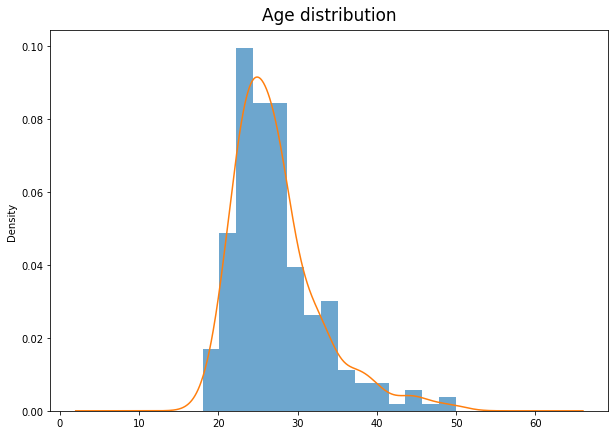

In [380]:
fig, ax = plt.subplots(figsize = (10,7))
dts["age"].plot(kind = "hist", density = True, alpha = 0.65, bins = 15)
dts["age"].plot(kind = "kde")
ax.set_title("Age distribution", size = 17, pad = 10)

Text(0.5, 1.0, 'Age distribution')

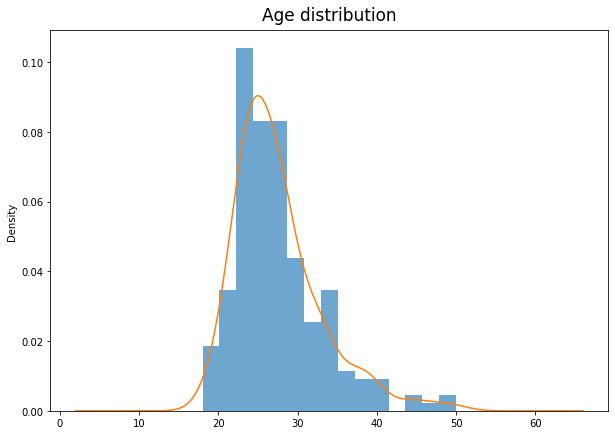

In [381]:
fig, ax = plt.subplots(figsize = (10,7))
man["age"].plot(kind = "hist", density = True, alpha = 0.65, bins = 15)
man["age"].plot(kind = "kde")
ax.set_title("Age distribution", size = 17, pad = 10)

Text(0.5, 1.0, 'Age distribution')

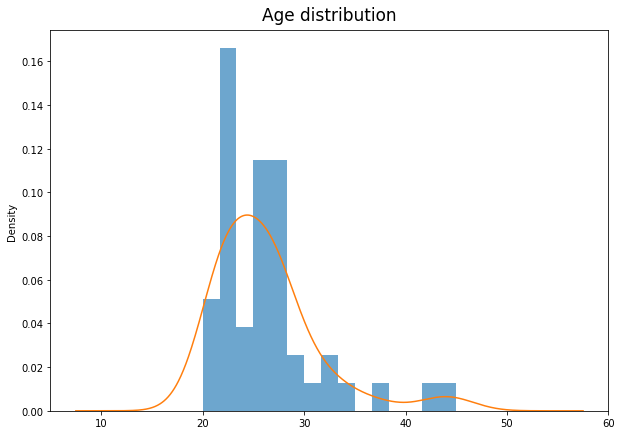

In [382]:

fig, ax = plt.subplots(figsize = (10,7))
woman["age"].plot(kind = "hist", density = True, alpha = 0.65, bins = 15)
woman["age"].plot(kind = "kde")
ax.set_title("Age distribution", size = 17, pad = 10)

### 4. Can we say that the average age (24 years old) of the observations can be considered as the average age of the population likely to participate in this bootcamp. Justify your answer

In [383]:
#here your codes
dts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gender                  250 non-null    object        
 1   application_date        250 non-null    datetime64[ns]
 2   education_level         250 non-null    object        
 3   job is formal           250 non-null    object        
 4   have_computer_home      250 non-null    object        
 5   internet_at_home        250 non-null    object        
 6   Communication channels  250 non-null    object        
 7   Bootcamp interest       250 non-null    object        
 8   quest_id                250 non-null    object        
 9   age                     250 non-null    float64       
 10  Commune_en              250 non-null    object        
 11  Departement             250 non-null    object        
 12  enroll_date             102 non-null    object    

### 5. Calculate the average age of participants for each communication channel

In [384]:
#here your codes
avg_channels = pd.pivot_table(data=dts, index= "Communication channels", values="age", aggfunc='mean')
for index in avg_channels.index:
  print(f"The average age for {index} communication channel is: {round(avg_channels.at[index, 'age'])}")

The average age for Ayiti Analytics Website communication channel is: 27
The average age for Bootcamp Alumni communication channel is: 26
The average age for ESIH communication channel is: 25
The average age for Facebook communication channel is: 27
The average age for Friend communication channel is: 27
The average age for Instagram communication channel is: 24
The average age for LinkedIn communication channel is: 30
The average age for WhatsApp communication channel is: 28
The average age for other communication channel is: 28
The average age for unknown communication channel is: 22


### 6. Display an age boxplot for each communication channel

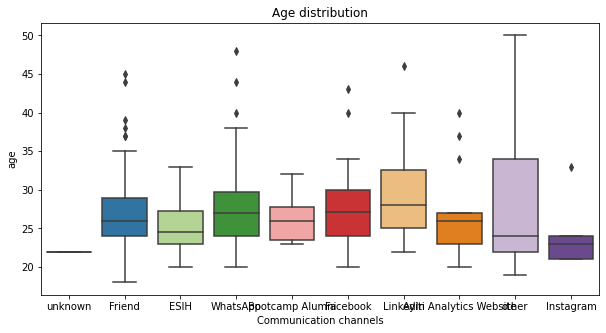

In [385]:
plt.figure(figsize=(10,5))
sns.boxplot( x=dts["Communication channels"], y=dts["age"], palette="Paired" );
plt.title("Age distribution")
plt.show()

### 7 .Is there a significant age difference between these groups

A one-way ANOVA uses the following null and alternative hypotheses:

H0 (null hypothesis): μ1 = μ2 = μ3 = … = μk (all the population means are equal)

H1 (Alternative hypothesis): at least one population mean is different from the rest

In [386]:
#here your codes
dts1 = dts[dts["Communication channels"]=="Ayiti Analytics Website"].age
dts2 = dts[dts["Communication channels"]=="Friend"].age
dts3 = dts[dts["Communication channels"]=="Facebook"].age
dts4 = dts[dts["Communication channels"]=="ESIH"].age
dts5 = dts[dts["Communication channels"]=="LinkedIn"].age
dts6 = dts[dts["Communication channels"]=="Instagram"].age
dts7 = dts[dts["Communication channels"]=="WhatsApp"].age
dts8 = dts[dts["Communication channels"]=="Bootcamp Alumni"].age
dts9 = dts[dts["Communication channels"]=="other"].age

In [387]:
tes_dts = f_oneway(dts1, dts2, dts3, dts4, dts5, dts6, dts7, dts8, dts9)
if tes_dts.pvalue>0.05:
  print("We fail to reject HO, there is no difference in the group age mean.")
else:
  print("There is a difference in the group mean age mean.")
tes_dts

We fail to reject HO, there is no difference in the group age mean.


F_onewayResult(statistic=1.2149809304679968, pvalue=0.2907198921134706)

### 8.Plan a BA strategy for each communication channel regarding the age group

In [388]:
#here your codes


### 9.According to the observations what is the probability of being in each channel of communication knowing your are a woman

In [389]:
#here your codes
comchanel = pd.crosstab(dts.gender, dts["Communication channels"], margins=True, normalize="index")
for col in comchanel.columns:
  print(f"The proba of {col} knowing woman is: {round(comchanel.at['female', col],3)}")

The proba of Ayiti Analytics Website knowing woman is: 0.085
The proba of Bootcamp Alumni knowing woman is: 0.17
The proba of ESIH knowing woman is: 0.106
The proba of Facebook knowing woman is: 0.128
The proba of Friend knowing woman is: 0.234
The proba of Instagram knowing woman is: 0.021
The proba of LinkedIn knowing woman is: 0.021
The proba of WhatsApp knowing woman is: 0.191
The proba of other knowing woman is: 0.043
The proba of unknown knowing woman is: 0.0


### 10.According to the observations what is the probability of being in each channel of communication knowing your are a man

In [390]:
comchanel

Communication channels,Ayiti Analytics Website,Bootcamp Alumni,ESIH,Facebook,Friend,Instagram,LinkedIn,WhatsApp,other,unknown
gender,,,,,,,,,,
female,0.085106,0.170213,0.106383,0.127660,0.234043,0.021277,0.021277,0.191489,0.042553,0.000000
male,0.054187,0.029557,0.064039,0.167488,0.275862,0.019704,0.068966,0.280788,0.034483,0.004926
All,0.060000,0.056000,0.072000,0.160000,0.268000,0.020000,0.060000,0.264000,0.036000,0.004000


In [391]:
for col in comchanel.columns:
  print(f"The proba of {col} knowing man is: {round(comchanel.at['male', col],3)}")

The proba of Ayiti Analytics Website knowing man is: 0.054
The proba of Bootcamp Alumni knowing man is: 0.03
The proba of ESIH knowing man is: 0.064
The proba of Facebook knowing man is: 0.167
The proba of Friend knowing man is: 0.276
The proba of Instagram knowing man is: 0.02
The proba of LinkedIn knowing man is: 0.069
The proba of WhatsApp knowing man is: 0.281
The proba of other knowing man is: 0.034
The proba of unknown knowing man is: 0.005


In [392]:
#here your codes

### 11. Deduce the probability of being a woman knowing each communication channel

In [393]:
gen_chan

Communication channels,Ayiti Analytics Website,Bootcamp Alumni,ESIH,Facebook,Friend,Instagram,LinkedIn,WhatsApp,other,unknown,All
gender,,,,,,,,,,,
female,0.266667,0.571429,0.277778,0.15,0.164179,0.2,0.066667,0.136364,0.222222,0.0,0.188
male,0.733333,0.428571,0.722222,0.85,0.835821,0.8,0.933333,0.863636,0.777778,1.0,0.812


In [394]:
#here your codes
gen_chan = pd.crosstab(dts.gender, dts["Communication channels"], margins=True, normalize="columns")
for col in gen_chan.columns:
  print(f"The proba of being a woman knowing knowing {col} is: {round(gen_chan.at['female', col], 3)}")

The proba of being a woman knowing knowing Ayiti Analytics Website is: 0.267
The proba of being a woman knowing knowing Bootcamp Alumni is: 0.571
The proba of being a woman knowing knowing ESIH is: 0.278
The proba of being a woman knowing knowing Facebook is: 0.15
The proba of being a woman knowing knowing Friend is: 0.164
The proba of being a woman knowing knowing Instagram is: 0.2
The proba of being a woman knowing knowing LinkedIn is: 0.067
The proba of being a woman knowing knowing WhatsApp is: 0.136
The proba of being a woman knowing knowing other is: 0.222
The proba of being a woman knowing knowing unknown is: 0.0
The proba of being a woman knowing knowing All is: 0.188


### 13. Deduce the probability of being a woman knowing each communication channel

In [395]:
# here your codes

### 14. Deduce the probability of being a man knowing each communication channel

In [396]:
#here your codes
for col in comchanel.columns:
  print(f"The proba of being a woman knowing knowing {col} is: {round(gen_chan.at['male', col],3)}")

The proba of being a woman knowing knowing Ayiti Analytics Website is: 0.733
The proba of being a woman knowing knowing Bootcamp Alumni is: 0.429
The proba of being a woman knowing knowing ESIH is: 0.722
The proba of being a woman knowing knowing Facebook is: 0.85
The proba of being a woman knowing knowing Friend is: 0.836
The proba of being a woman knowing knowing Instagram is: 0.8
The proba of being a woman knowing knowing LinkedIn is: 0.933
The proba of being a woman knowing knowing WhatsApp is: 0.864
The proba of being a woman knowing knowing other is: 0.778
The proba of being a woman knowing knowing unknown is: 1.0


### 15 Display a plot to see Gender vs Communication Channels .Is there any dependency between communication channels and gender?

0.0107 is smaller than 0.05. We conclude that there is dependency betwenn these variables.


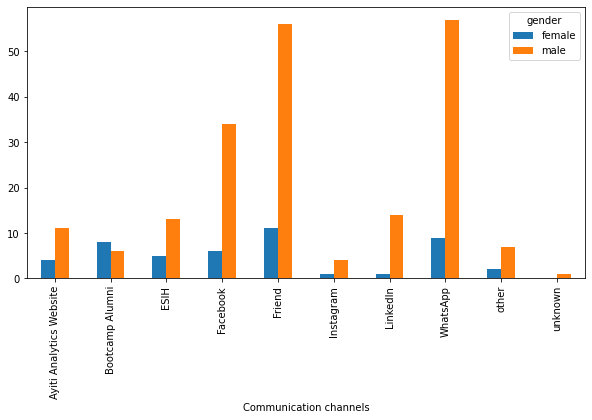

In [397]:
#here your codes
com_gen = pd.crosstab(dts["Communication channels"], dts["gender"], normalize=False, margins = True)
chi2, pval, dof, expected = chi2_contingency(com_gen[com_gen.All>5].iloc[:-1,:-1])
if pval<0.05:
    print(f"{round(pval,4)} is smaller than 0.05. We conclude that there is dependency betwenn these variables.")
com_gen.iloc[:-1,:-1].plot.bar(figsize=(10,5))

### 16 Use the same method to display plot and know if is there any dependency between communication channels and Bootcamp Insterest?

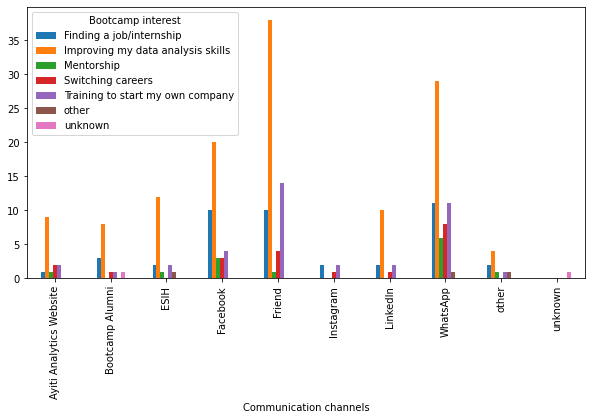

In [398]:
# here your codes
com_int = pd.crosstab(dts["Communication channels"], dts["Bootcamp interest"], normalize=False, margins = True)
chi2, pval, dof, expected = chi2_contingency(com_int[com_int.All>5].iloc[:-1,:-1])
if pval<0.05:
    print(f"{round(pval,4)} is smaller than 0.05. We conclude that there is dependency betwenn these variables.")
com_int.iloc[:-1,:-1].plot.bar(figsize=(10,5))

### 17.Plan a BA  strategy for each communication channel, Bootcamp Insterest regarding the gender 

In [399]:

#here your codes

### 18.Plan a BA  strategy for each communication channel, Bootcamp Insterest regarding the gender

In [400]:
# here your codes

### 19. Calculate 
    * P(Bootcamp Insterest,Communication channels,Gender/Payed=yes)
    * P(Bootcamp Insterest,Communication channels,Gender/Payed=no)

In [401]:
# shape
yes=len(dts[dts["payed"]=='yes'])
no=len(dts)-yes

In [402]:
dts1=pd.pivot_table(dts[dts['payed']=="yes"],values='quest_id',index=['Bootcamp interest','Communication channels','gender'], aggfunc='count')
dts1=dts1/yes
print('Probabilities for a payed applicant by his interest for the bootcamp, his gender and his communication channel')
print(dts1)

Probabilities for a payed applicant by his interest for the bootcamp, his gender and his communication channel
                                                                  quest_id
Bootcamp interest                 Communication channels  gender          
Finding a job/internship          Ayiti Analytics Website male    0.015385
                                  Bootcamp Alumni         female  0.015385
                                  ESIH                    male    0.015385
                                  Facebook                male    0.015385
                                  Friend                  female  0.015385
                                                          male    0.030769
                                  Instagram               male    0.015385
                                  LinkedIn                male    0.015385
                                  WhatsApp                female  0.015385
                                                          male  

In [403]:

dts2=pd.pivot_table(dts[dts['payed']=="no"],values='quest_id',index=['Bootcamp interest','Communication channels','gender'], aggfunc='count')
dts2=dts2/no
print('Probabilities for a non-payed applicant by his interest for the bootcamp, his gender and his communication channel')
print(dts2)
dts2

Probabilities for a non-payed applicant by his interest for the bootcamp, his gender and his communication channel
                                                                  quest_id
Bootcamp interest                 Communication channels  gender          
Finding a job/internship          Bootcamp Alumni         female  0.010811
                                  ESIH                    male    0.005405
                                  Facebook                female  0.010811
                                                          male    0.037838
                                  Friend                  female  0.016216
                                                          male    0.021622
                                  Instagram               male    0.005405
                                  LinkedIn                male    0.005405
                                  WhatsApp                male    0.037838
                                  other                   ma

quest_id
Bootcamp interest                 Communication channels  gender          
Finding a job/internship          Bootcamp Alumni         female  0.010811
                                  ESIH                    male    0.005405
                                  Facebook                female  0.010811
                                                          male    0.037838
                                  Friend                  female  0.016216
                                                          male    0.021622
                                  Instagram               male    0.005405
                                  LinkedIn                male    0.005405
                                  WhatsApp                male    0.037838
                                  other                   male    0.010811
Improving my data analysis skills Ayiti Analytics Website female  0.010811
                                                          male    0.032432
                                  Bootcamp Alumni         female  0.010811
                                  ESIH                    female  0.016216
                                                          male    0.037838
                                  Facebook                male    0.070270
                                  Friend                  female  0.021622
                                                          male    0.097297
                                  LinkedIn                male    0.043243
                                  WhatsApp                female  0.016216
                                                          male    0.108108
                                  other                   female  0.005405
                                                          male    0.010811
Mentorship                        Ayiti Analytics Website male    0.005405
                                  ESIH                    female  0.005405
                                  Facebook                female  0.010811
                                                          male    0.005405
                                  Friend                  male    0.005405
                                  WhatsApp                male    0.032432
Switching careers                 Ayiti Analytics Website female  0.005405
                                                          male    0.005405
                                  Facebook                male    0.016216
                                  Friend                  male    0.021622
                                  Instagram               male    0.005405
                                  LinkedIn                male    0.005405
                                  WhatsApp                female  0.005405
                                                          male    0.037838
Training to start my own company  Ayiti Analytics Website female  0.005405
                                  Bootcamp Alumni         female  0.005405
                                  ESIH                    female  0.005405
                                                          male    0.005405
                                  Facebook                male    0.016216
                                  Friend                  female  0.005405
                                                          male    0.054054
                                  Instagram               female  0.005405
                                                          male    0.005405
                                  LinkedIn                male    0.010811
                                  WhatsApp                female  0.005405
                                                          male    0.043243
                                  other                   male    0.005405
other                             other                   male    0.005405
unknown                           Bootcamp Alumni         male    0.005405
                

### 20 reduce 
* P(Payed="yes"/Bootcamp Insterest="Increase Skill",Communication channels="Friend",Gender="male")
* P(Payed="no"/Bootcamp Insterest="Increase Skill",Communication channels="Friend",Gender="male")

In [ ]:
dts.columns

In [ ]:
# here your codes
dts['Communication channels'].unique()

In [ ]:
# here your code
dts3=dts[(dts['Bootcamp interest']=='Improving my data analysis skills')& (dts['Communication channels']=='Friend') & (dts['gender']=='male')]
ts3=dts3['payed'].value_counts(normalize=1 )
ts3.rename(index={"yes":"Probability that the applicant pays knowing he wants to improve her skills, he is male and the communication channel is a friend",
'no':"Probability that the applicant doesn't pay knowing he wants to improve her skills, he is male and the communication channel is a friend"}, inplace=True)
ts3

### Based on these findings, propose strategies to increase our sales?

According to the results, it is proposed that AYITI ANALYTICS focus on the friends of the Bootcamp alumni to talk to their alumni if they want to increase their sales because the probability that a candidate will pay knowing that he wants to improve his skills and that he is a man and that his communication channel is a friend with a high percentage could be much more beneficial for AYITI ANALYTICS 
